In [2]:
import os
import time
import re
import numpy as np
import math
from os import listdir
from os.path import isfile, join

from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as patches
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.gridspec as gridspec

import paramiko
import subprocess

from numba import vectorize
from numba import jit

from scipy.ndimage import imread
from scipy import ndimage
from scipy.ndimage.filters import gaussian_filter
from skimage.morphology import square, disk, dilation

from PIL import Image
import pandas as pd

from utils import read_tiff, make_dir, read_images_from_directory, smooth
#from monitor_utils import *

In [41]:
#---------------------------
#   Colors
#---------------------------

blue = (57 / 255.0, 106 / 255.0, 177 / 255.0)
red = (204/ 255.0, 37/ 255.0, 41/ 255.0 )
green = (62/ 255.0, 150/ 255.0, 81/ 255.0 )  
grey = (128/ 255.0, 133/ 255.0, 133/ 255.0 )
gold = (237/ 255.0, 218/ 255.0, 116/ 255.0 )

#---------------------------
#   Fonts
#---------------------------

title_font_size = 20
label_font_size = 16
ticks_font_size = 16



def read_flow_from_components(file_u, file_v, shape):
    u = np.fromfile(file_u, dtype='float32', sep="")
    u = u.reshape(shape)
    
    v = np.fromfile(file_v, dtype='float32', sep="")
    v = v.reshape(shape)
    
    return u,v

def read_raw_image(file_name, shape):
    img = np.fromfile(file_name, dtype='float32', sep="")
    img = img.reshape(shape)
    
    return img
    

def read_raw_files_save_as_multitiff_stack(path, file_name, shape, mask=""):
    if mask == "":
        files = sorted([f for f in listdir(path) if isfile(join(path, f))])
    else:
        files = sorted([f for f in listdir(path) if isfile(join(path, f)) and f.find(mask) != -1])
        
    #print('Number of images to convert:', len(files))
    
    imlist = []
    for f in files:
        #im = np.array(Image.open(p + f))
        #imlist.append(Image.fromarray(m))

        np_im = read_raw_image(path + f, shape)
        imlist.append(Image.fromarray(np_im))

    imlist[0].save(file_name, save_all=True, append_images=imlist[1:])

    #print('OK')


    
#----------------------------#
# Time analysis              #
#----------------------------#
def time_analysis(images, corr_images, cx, cy, rx, ry, y_pos=60, ax=None, region='all', show=False, color='k'):
    
    if  not ax:
        ax  = plt.subplot(111)

    #def avg_nonzero(a): 
    #    return np.mean(a[a > 0])

    all_shots_vel = []

    #for s in range(1):    
    for s in range(shots_num):
        # Get sequence for the shot
        seq = images[s*seq_length:(s+1)*seq_length]
        seq_corr = corr_images[s*seq_length:(s+1)*seq_length]

        mean_vel_values = []

        #for i in range(1):
        for i in range(seq_length): 

            im = seq[i][cy-ry:cy+ry,cx-rx:cx+rx]
            c = seq_corr[i][cy-ry:cy+ry,cx-rx:cx+rx]
            #print(cy-r_2, cx-r_2)

            # Filtering
            
            # 1. Put away large velocity outliers
            #filtered_amp = np.where(im < 10, im, 0)
            if filter_high:
                im = np.where(im < max_vel_in_pixels, im, 0)
            
                
            # 2. Drop velocities with low correlation values
            if filter_corr:
                filtered_corr = np.where(c > min_corr_value, 1, 0)
                im = im*filtered_corr
                #filtered_corr = 1.0
                
            # 3. Drop zero velocities from avareging
            if filter_zero:
                nonzero_values = im[im > min_vel_in_pixels]
                if len(nonzero_values) == 0:
                    im = 0.0
                else:
                    im = np.mean(nonzero_values)
            
                
            
            #amp_nonzeros_mean = np.mean(filtered_amp[filtered_amp > 0])
            if not (filter_high and filter_zero):
                im = np.mean(im)
                

            # Convert to m/s
            im = im*vel_factor
            #amp_nonzeros_mean = amp_nonzeros_mean*vel_factor

            mean_vel_values.append(im)
            #mean_vel_values.append(amp_nonzeros_mean)

        all_shots_vel.append(mean_vel_values)
        #ax.plot(mean_vel_values, linewidth=1.0, alpha=0.3)

    smooth_mask = 4
    all_shots_mean = np.mean(np.array(all_shots_vel), axis=0)
    ax.plot(smooth(all_shots_mean, smooth_mask, 'flat'), linewidth=2.0, color=color, linestyle='dashed')
    
    ax.set_title('Velocity evolution, region: ' + region, size=title_font_size)
    
    x_lables = ['{:.1f}'.format(x) for x in np.arange(0, (0+seq_length)+1, 5)*sample_rate / 1000.0]
    x_ticks = np.arange(0, seq_length+1, 5)
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_lables, fontsize = ticks_font_size)
    
    ax.set_ylabel('velocity, [m\s]', size=label_font_size)
    ax.set_xlabel('time from injection, [s]', size=label_font_size)


    overall_mean = np.mean(all_shots_mean)
    overall_std = np.std(all_shots_mean)

    #print('Overall average in region {0:.2f} m/s'.format(overall_mean))
    #print('Overall variation in region {0:.2f} m/s'.format(overall_std))
    #print('Variation in percent {0:.1f} %'.format(overall_std / overall_mean * 100))
    
    ax.text(1, y_pos, 'Mean: {0:.2f} m/s'.format(overall_mean), fontsize=14, color=color)
    ax.text(26, y_pos, 'STD: {0:.2f} m/s'.format(overall_std), fontsize=14, color=color)

    ax.set_ylim(vel_min,vel_max)
    ax.yaxis.set_tick_params(labelsize=label_font_size)
    
    if show:
        plt.show()
        
    return overall_mean, overall_std


def make_analysis_figure(data, measure_name, measure_file):


    print('Making figure...')
    
  
    #measure_name = 'Mean filtered velocity'
    #measure_file = 'amp_mean_filter'

    data = data*vel_factor

    #amp_seq = images


    # Setup figure
    fig = plt.figure(1)

    fig.set_size_inches(20/2 + 2, 14, forward=True)
    plt.subplots_adjust(top=0.95, bottom=0.06, left=0.1, right=0.90, hspace=0.3 )

    gs = gridspec.GridSpec(2, 1, height_ratios=[1.3,1])

    #-------------------------------------------
    # Figure 1: Velocity maps
    #-------------------------------------------

    # Setup figure
    ax0 = plt.subplot(gs[0,:])

    imx = ax0.imshow(data, vmin=vel_min, vmax=vel_max, cmap='inferno')
    ax0.set_title('Dataset: '+ dataset +', '+ measure_name, size=title_font_size, y=1.05)    
    ax0.set_xlabel('distance, [mm]', size=label_font_size)
    ax0.set_ylabel('distance, [mm]', size=label_font_size)

    width = data.shape[1]
    x_lables = ['{:.1f}'.format(x) for x in np.arange(0.0, width+1, 100.0) /1000.0*pixel_size]
    
    x_ticks = np.arange(0, width+1, 100)
    ax0.set_xticks(x_ticks)
    ax0.set_xticklabels(x_lables, fontsize = ticks_font_size)

    height = data.shape[0]

    
    y_lables = ['{:.1f}'.format(x) for x in np.arange(0.0, height+1, 100.0) /1000.0*pixel_size]
    y_ticks = np.arange(0, height+1, 100)
    ax0.set_yticks(y_ticks)
    ax0.set_yticklabels(y_lables)

    ax0.yaxis.set_tick_params(labelsize=label_font_size)

    axins0 = inset_axes(ax0,
                       width="1.5%",  # width = 10% of parent_bbox width
                       height="100%",  # height : 50%
                       loc=3,
                       bbox_to_anchor=(1.02, 0., 1, 1),
                       bbox_transform=ax0.transAxes,
                       borderpad=0                    
                       )

    # Separation lines between combined images

    clb = plt.colorbar(imx, cax=axins0)
    clb.ax.tick_params(labelsize=ticks_font_size)

    #step = int(350 / 2)
    #step = int(250 / 2)
    
    step = int(width / 4)

    ax0.axvline(step*1,linewidth=2, color=blue, alpha=0.7)
    ax0.axvline(step*2,linewidth=2, color=red, alpha=0.7)
    ax0.axvline(step*3,linewidth=2, color=green, alpha=0.7)


    # Create a Rectangle patch
    rect1 = patches.Rectangle((step*1 - rx, height/2-ry),2*rx,2*ry,linewidth=1, linestyle='--',edgecolor=blue,facecolor='none', alpha=1.0)
    ax0.add_patch(rect1)

    rect2 = patches.Rectangle((step*2 - rx, height/2-ry),2*rx,2*ry,linewidth=1, linestyle='--',edgecolor=red,facecolor='none', alpha=1.0)
    ax0.add_patch(rect2)

    rect3 = patches.Rectangle((step*3 - rx, height/2-ry),2*rx,2*ry,linewidth=1, linestyle='--',edgecolor=green,facecolor='none', alpha=1.0)
    ax0.add_patch(rect3)

    ax0.grid(False)

    #plt.show()
    #fig.savefig(path + dataset + '_comb_' + measure[1] + '_map.png')


    #-------------------------------------------
    # Figure 2: Velocity profiles
    #-------------------------------------------
    
    if plot_profiles:

        plt.style.use('seaborn')

        #fig.set_size_inches(25, 8, forward=True)
        #plt.subplots_adjust(left=0.05, right=0.95, wspace=0.1)

        smooth_mask = 4
        avg_width = 2
         
        #num_points = 7
        #
        #if region == '0': 
        #    offset = 300 # Manuall offset for the Tile 0
        #else:
        #    image_width = width*pixel_size / 1000 # in mm
        #    shift = 2.5 # in mm
        #    offset = int((image_width - shift) * 1000 / pixel_size) # in pixels
        #    offset = 50
#
        #print('Offset:', offset)
        #
        ## Profiles along spraying direction
        #for i in range(0, int((width-offset)/step_in_pixels)):
        #    
        #    x = int(offset + step_in_pixels*i)
        #    
        #    ax0.axvline(x,linewidth=1, color=grey, alpha=1.0)
        #    
        #    vels = []
        #    
        #    for p in range(num_points):
        #        
        #        y = int(height / (num_points + 1) * (p+1))
        #        
        #        rect = patches.Rectangle((x - px, y-py),2*px,2*py,linewidth=1,edgecolor=blue,facecolor='none', alpha=1.0)
        #        ax0.add_patch(rect)
        #        
        #        vel_patch_mean =  np.mean(data[y-py:y+py, x-px:x+px])
        #        vels.append(vel_patch_mean)
        #    
        #    #print(vels)
      
        
        # Subplot 2  
        
        vel_profile_1 = np.mean(data[:,step*1-avg_width:step*1+avg_width], axis=1)
        vel_profile_2 = np.mean(data[:,step*2-avg_width:step*2+avg_width], axis=1)
        vel_profile_3 = np.mean(data[:,step*3-avg_width:step*3+avg_width], axis=1)
        


        np.savetxt(results_path + '_vel_profile_A.txt', vel_profile_1, fmt='%.5f')
        np.savetxt(results_path + '_vel_profile_B.txt', vel_profile_2, fmt='%.5f')
        np.savetxt(results_path + '_vel_profile_C.txt', vel_profile_3, fmt='%.5f')

        ax1 = plt.subplot(gs[1,0])
        ax1.set_title('spray region: '+region, size=title_font_size)

        ax1.plot(smooth(vel_profile_1, smooth_mask, 'flat'), linewidth=1.5, color=blue)
        ax1.plot(smooth(vel_profile_2, smooth_mask, 'flat'), linewidth=1.5, color=red)
        ax1.plot(smooth(vel_profile_3, smooth_mask, 'flat'), linewidth=1.5, color=green)
        
        ax1.set_ylim(vel_min, vel_max)
        ax1.set_ylabel('velocity, [m\s]', size=label_font_size)
        ax1.set_xlabel('distance, [mm]', size=label_font_size)
        ax1.set_xticks(y_ticks)
        ax1.set_xticklabels(y_lables, fontsize = ticks_font_size)
        ax1.yaxis.set_tick_params(labelsize=label_font_size)
        
    
    #-------------------------------------------
    # Figure 3: Velocity time evolution
    #-------------------------------------------
    
    if plot_time_evolution:
        # Subplot 2
        ax4 = plt.subplot(gs[2,0])
        avg_vel_A, std_vel_A = time_analysis(amp_seq, corr, int(width/4), int(height/2), rx, ry, vel_min +25, ax4, region=region, show=False, color=blue)
        avg_vel_B, std_vel_B = time_analysis(amp_seq, corr, int(width/2), int(height/2), rx, ry, vel_min +15, ax4, region=region, show=False, color=red)
        avg_vel_C, std_vel_C = time_analysis(amp_seq, corr, int(3*width/4), int(height/2), rx, ry, vel_min +5, ax4, region=region, show=False, color=green)


    #all_results_path = 'y:\\projects\\pn-reduction\\2018_03_esrf_mi1325\\Phantom\\Glasduese\\analysis_all_results\\'

    fig.savefig(results_path + dataset + '_fig_'+ measure_file +'.png')
    #fig.savefig(all_results_path + region + '\\' + d + '_' + dataset + '_' + region + '_comb_'+ measure_file +'_fig.png')


    #-------------------------------------------
    # Summary results table
    #-------------------------------------------

    #res = [date, dataset, region, avg_vel_A, std_vel_A, avg_vel_B, std_vel_B, avg_vel_C, std_vel_C]

    #df.loc[len(df)] = res

    print('OK')
    #results_table.append(res)

    if show_plot:
        plt.draw()
        plt.show()
          
def count_zero(a):  
    eps = 1e-5
    #vals = a[a < eps]
    vals = np.where(a < min_vel_in_pixels, 1, 0)
    
    if len(vals) == 0:
        return 0.0
    else:
        return np.sum(vals)
   
def max_outliers(a):  
    eps = 1e-5
    #vals = a[a < eps]
    vals = np.where(a > max_vel_in_pixels, a, 0)
    
    if len(vals) == 0:
        return 0.0
    else:
        return np.max(vals)

def high_corr(a):  
    eps = 1e-5
    #vals = a[a < eps]
    vals = np.where(a > min_corr_value, a, 0)
    
    if len(vals) == 0:
        return 0.0
    else:
        return np.mean(vals)
    
def low_corr(a):  
    eps = 1e-5
    #vals = a[a < eps]
    vals = np.where(a < min_corr_value, a, 0)
    
    if len(vals) == 0:
        return 0.0
    else:
        return np.mean(vals)

    
def plot_metrics():
    
    #a = np.array([[0,0,1,3,0], [0,0,1,3,1]])
    corr_max = np.apply_along_axis(high_corr, 0, corr)
    corr_min = np.apply_along_axis(low_corr, 0, corr)

    print(np.mean(corr_min))

    amp_zeros = np.apply_along_axis(count_zero, 0, amp)
    amp_outliers = np.apply_along_axis(max_outliers, 0, amp)
    #print(amp_zeros)

    fig = plt.figure(1)

    fig.set_size_inches(20/3 + 2, 14, forward=True)
    plt.subplots_adjust(top=0.95, bottom=0.06, left=0.1, right=0.90, hspace=0.3 )

    gs = gridspec.GridSpec(4, 1, height_ratios=[1,1,1,1])


    # Setup figure
    ax0 = plt.subplot(gs[0,:])
    imx0 = ax0.imshow(corr_max, cmap='inferno')
    ax0.set_title('Keep correlation, Mean')
    ax0.grid(False)
    plt.colorbar(imx0, ax=ax0)

    ax1 = plt.subplot(gs[1,:])
    imx1 = ax1.imshow(corr_min, cmap='inferno')
    ax1.set_title('Drop correlation, Mean')
    ax1.grid(False)
    plt.colorbar(imx1, ax=ax1)

    ax2 = plt.subplot(gs[2,:])
    imx2 = ax2.imshow(amp_zeros, cmap='inferno')
    ax2.set_title('Low velocity, count')
    ax2.grid(False)
    plt.colorbar(imx2, ax=ax2)

    ax3 = plt.subplot(gs[3,:])
    imx3 = ax3.imshow(amp_outliers, cmap='inferno')
    ax3.set_title('Fast outliers velocity, Max')
    ax3.grid(False)
    plt.colorbar(imx3, ax=ax3)

    plt.show()

    fig.savefig(results_path + dataset + '_metrics_fig.png')
    
def check_data_frames():
    
    fig = plt.figure(1)

    fig.set_size_inches(14, 7, forward=True)
    plt.subplots_adjust(top=0.95, bottom=0.04, left=0.05, right=0.95, hspace=0.3 )

    gs = gridspec.GridSpec(2, 2)
    
    flat1 = images[flats_start]
    ax1 = plt.subplot(gs[0,0])
    ax1.imshow(flat1, cmap='gray')
    ax1.set_title('First flat field. index={}'.format(flats_start))
    plt.grid(False)
    

    flat2 = images[flats_end]
    ax2 = plt.subplot(gs[0,1])
    ax2.imshow(flat2, cmap='gray')
    ax2.set_title('Last flat field. index={}'.format(flats_end))
    plt.grid(False)


    im1 = images[start_spray]
    ax3 = plt.subplot(gs[1,0])
    ax3.imshow(im1, cmap='gray')
    ax3.set_title('First data frame. index={}'.format(start_spray))
    plt.grid(False)
 

    im2 = images[start_spray+seq_length]
    ax4 = plt.subplot(gs[1,1])
    ax4.imshow(im2, cmap='gray')
    plt.grid(False)
    ax4.set_title('Last data frame. index={}'.format(start_spray))
    
    plt.show()
    
    im1 = images[start_spray][y0:y0+h, x0:x0+w]
    plt.grid(False)
    plt.imshow(im1, vmin=30, vmax=150, cmap='gray')
    plt.title('Cropped frame. Input for processing')
    
    plt.show()
    

def summarize_velocity_profiles(data, df, pos, num_vert_point=5):
    
    width = data.shape[1]
    height = data.shape[0]

    if region == '0': 
        offset = 306 # Manuall offset for the Tile 0
    else:
        image_width = width*pixel_size / 1000 # in mm
        shift = 2.5 # in mm
        offset = int((image_width - shift) * 1000 / pixel_size) + int(step_in_pixels / 2)  # in pixels
        
    #print('Offset:', offset)

    # Profiles along spraying direction
    
    num_of_profiles = int((width-offset)/step_in_pixels)
    
    for i in range(0, num_of_profiles+1):

        x = int(offset + step_in_pixels*i)
        
        #ax.axvline(x,linewidth=1, color=grey, alpha=1.0)

        vels = []

        for p in range(num_vert_point):

            y = int(height / (num_vert_point + 1) * (p+1))
            
            #rect = patches.Rectangle((x - px, y-py),2*px,2*py,linewidth=1,edgecolor=blue,facecolor='none', alpha=1.0)
            #ax.add_patch(rect)
            
            vel_patch_mean =  np.mean(data[y-py:y+py, x-px:x+px])
            vels.append(vel_patch_mean)
        
        #res = [dataset, region, pos + step_in_mm*(i+1)] + ['{0:.1f}'.format(x) for x in vels]
        res = [dataset, region, pos + step_in_mm*(i+1)] + vels
        
        df.loc[len(df)] = res
        
    
    return pos + step_in_mm*(i+1)   


def filter_and_summarize_velocities(amp, corr, peaks, flow_x, flow_y):
    
    width = amp.shape[2]
    height = amp.shape[1]

    cx = int(width / 2) 
    cy = int(height / 2)

    rx = 20
    ry = 10
    
    # 1. Mean velocity without any filtering
    amp_mean = np.mean(images, axis=0)
    amp_mean_unfiltered_center = np.mean(amp_mean[cy-ry:cy+ry,cx-rx:cx+rx])

    im_res = Image.fromarray(amp_mean*vel_factor)
    im_res.save(results_path + dataset + '_Tile_d' +region + '_amp_mean_nofilter.tif')
    amp_mean = np.mean(images, axis=0)
    print('mean:', amp_mean_unfiltered_center*vel_factor)

    # 2. Mean velocity with filtering on the correlation coefficient
    filtered_corr = np.where(corr > min_corr_value, 1, 0)

    filtered_corr_mean = avg_non_zero_full(images*filtered_corr)
    amp_mean_filtered_corr_center = np.mean(filtered_corr_mean[cy-ry:cy+ry,cx-rx:cx+rx])

    im_res = Image.fromarray(filtered_corr_mean*vel_factor)
    im_res.save(results_path + dataset + '_Tile_d' +region + '_amp_mean_filter_corr.tif')
    print('corr>0.2, center:', amp_mean_filtered_corr_center*vel_factor)

    # 3. Mean velocity with filtering on velocities
    perc_filtering_threshold = 0.5
    amp_mean_truth = 10

    min_vel_in_pixels = (1.0 - perc_filtering_threshold)*amp_mean_truth
    max_vel_in_pixels = (1.0 + perc_filtering_threshold)*amp_mean_truth

    filtered_amp_seq = np.where(np.all([images > min_vel_in_pixels, images < max_vel_in_pixels, np.abs(flow_x) > np.abs(flow_y)], axis=0), images, 0)

    filtered_amp_mean  = avg_non_zero_full(filtered_amp_seq)
    amp_mean_filtered_center = np.mean(filtered_amp_mean[cy-ry:cy+ry,cx-rx:cx+rx])

    im_res = Image.fromarray(filtered_amp_mean*vel_factor)
    im_res.save(results_path + dataset + '_Tile_d' +region + '_amp_mean_filter_amp.tif')
    print('amp +/- 50%:', amp_mean_filtered_center*vel_factor)

    # 4. Mean velocity with filtering on local peak height
    filtered_peak = np.where(peak > corr / 2.0, 1, 0)

    filtered_peak_mean = avg_non_zero_full(vec_mul3(images,filtered_corr,filtered_peak))
    amp_mean_filtered_center = np.mean(filtered_peak_mean[cy-ry:cy+ry,cx-rx:cx+rx])

    im_res = Image.fromarray(filtered_peak_mean*vel_factor)
    im_res.save(results_path + dataset + '_Tile_d' +region + '_amp_mean_filter_peak.tif')
    print('peak:', amp_mean_filtered_center*vel_factor)

    # 5. Mean velocity with filtering on all constraints
    filtered_all_mean = avg_non_zero_full(vec_mul3(filtered_amp_seq,filtered_corr,filtered_peak))
    amp_mean_filtered_center = np.mean(filtered_all_mean[cy-ry:cy+ry,cx-rx:cx+rx])

    im_res = Image.fromarray(filtered_all_mean*vel_factor)
    im_res.save(results_path + dataset + '_Tile_d' +region + '_amp_mean_filter_all.tif')
    print('all:', amp_mean_filtered_center*vel_factor)
    
    return amp_mean, filtered_corr_mean, filtered_amp_mean, filtered_peak_mean, filtered_all_mean  


def avg_nonzero(a): 
    
    non_zero_vals = a[a > 0]
    
    if len(non_zero_vals) == 0:
        return 0.0
    else:
        return np.mean(non_zero_vals)
    
def std_nonzero(a): 
    
    non_zero_vals = a[a > 0]
    
    if len(non_zero_vals) == 0:
        return 0.0
    else:
        return np.std(non_zero_vals)
    
@jit
def avg_non_zero_numba(a):
    num = 0
    sum_val = 0
    
    for i in range(len(a)):
        if a[i] > 0:
            sum_val += a[i]
            num += 1
    if num == 0:
        return 0
        
    return sum_val / num

@jit
def avg_non_zero_full(a):
    
    nz = a.shape[0]
    ny = a.shape[1]
    nx = a.shape[2]
    
    res = np.zeros_like(a[0])
    
    for i in range(ny):
        for j in range(nx):
             
            num = 0
            sum_val = 0
            
            for k in range(nz):

                val = a[k,i,j]
                
                if val > 0:
                    sum_val += val                    
                    num += 1
                    
            if num == 0:
                res[i,j] = 0
            else:
                res[i,j] = sum_val / num 
                
    return res
  
def mul3(a, b, c):
    return a*b*c

def mul4(a, b, c, d):
    return a*b*c*d

vec_mul3 = vectorize('float64(float64, float64, float64)', target='parallel')(mul3)

## Settings

In [6]:
#------------------------------
# Analysis settings
#------------------------------

#datasets = ['17_3_18_1', '17_3_23_1', '17_3_5_1', '17_3_7_3']
#regions = ['0', '2.5', '5', '7.5', '10', '12.5', '15', '17.5', '20']

regions = ['0', '2.5', '5', '7.5', '10']

dataset = '17_3_5_1'
region = regions[0]

# From local computer
path_input = 'y:\\projects\\pn-reduction\\2018_09_esrf_me1516\\Phantom\\' + dataset + '\\' + dataset + '_Tile_d' +region + '\\'

# From Linux servers
path_input = u'/mnt/LSDF/projects/pn-reduction/2018_09_esrf_me1516/Phantom/' + dataset + '/' + dataset + '_Tile_d' +region + '/'

#path_input = 'y:\\projects\\pn-reduction\\2018_09_esrf_me1516\\Phantom\\test\\' + dataset + '_Tile_d' +region + '\\'
results_path = path_input
file_name = dataset + '_Tile_d' +region+'.tif'

max_read_images = 200
shots_num     = 1
seq_length    = max_read_images

sample_rate = 31.25 

pixel_size = 2.7 # pixel size in micrometers. Phantom Dataset: 2_2_3_10xNUV+tube200mm_A_
#pixel_size = 2.58 # pixel size in micrometers. Phantom. Estimated from shift

#pixel_size = 3.0 # Dataset: 17.2_2_3_10xNUV_A_
#pixel_size = 3.37 # Dataset: Schimadzu multiexposure


bunch_period = 176  # 176 ns bunch separation period
time_factor = bunch_period / 1000.0   # in microseconds
vel_factor = pixel_size / time_factor

# Filtering paramters
filter_high = True
filter_zero = True
filter_corr = True
            
#max_vel_in_pixels = 11
#min_vel_in_pixels = 5

min_corr_value = 0.2
perc_filtering_threshold = 0.3
perc_outliers_threshold = 0.5

vel_min = 100
vel_max = 170

# Radius of the pacth for overall statistics analysis
rx = 40
ry = 20

show_plot = False

## Read data

In [22]:
start = time.time()
    
images = read_tiff(path_input + dataset + '_Tile_d' +region +'_amp_seq.tif', max_read_images)
corr   = read_tiff(path_input + dataset + '_Tile_d' +region + '_corr_seq.tif', max_read_images)
peak   = read_tiff(path_input + dataset + '_Tile_d' +region + '_peak_seq.tif', max_read_images)
flow_x   = read_tiff(path_input + dataset + '_Tile_d' +region + '_flow_x_seq.tif', max_read_images)
flow_y   = read_tiff(path_input + dataset + '_Tile_d' +region + '_flow_y_seq.tif', max_read_images)

end = time.time()
print ('Time elapsed: ', (end-start))

Time elapsed:  30.264304876327515


## Start Analysis

In [37]:

nofilter, corr_filter, amp_filter, peak_filter, all_filter = filter_and_summarize_velocities(images, corr, peak, flow_x, flow_y)

mean: 149.8739150437442
corr>0.2, center: 151.0365404845071
amp +/- 50%: 152.25017179142347
peak: 155.22494502594077
all: 155.20495444425788


Making figure...
OK


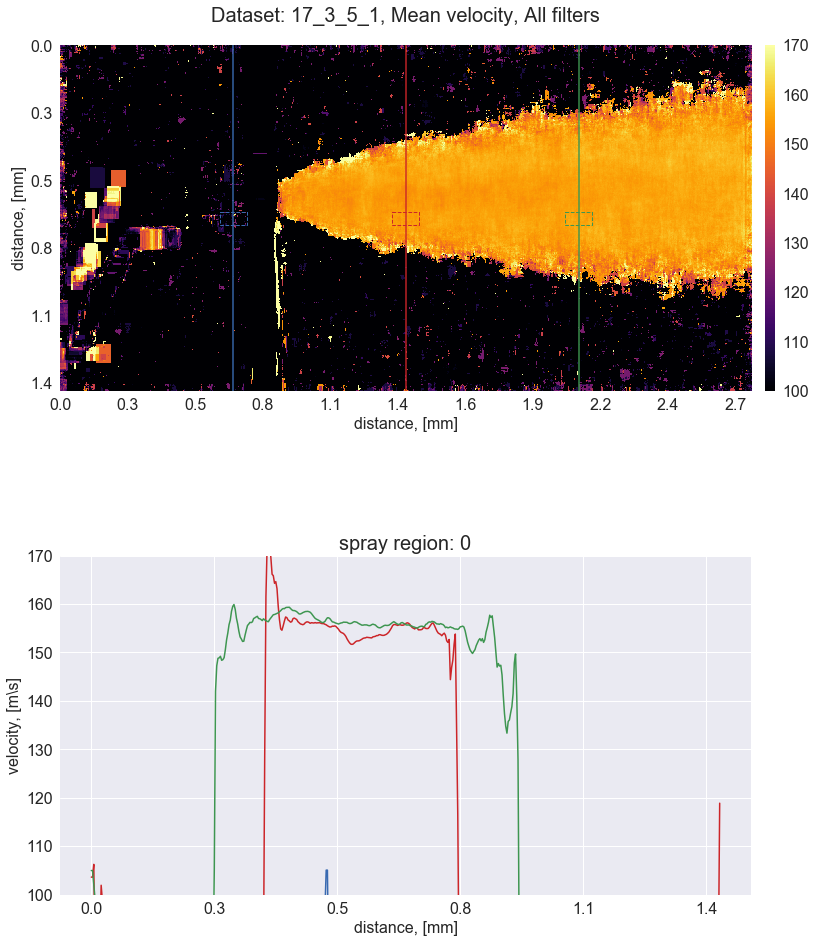

In [50]:
plot_velocity_map = True
plot_profiles = True
plot_time_evolution = False

#make_analysis_figure(nofilter, 'Mean velocity, No filter', 'amp_mean_nofilter')
#make_analysis_figure(corr_filter, 'Mean velocity, Correlation filter', 'amp_mean_filter_corr')
#make_analysis_figure(amp_filter, 'Mean velocity, Velocity filter', 'amp_mean_filter_amp')
#make_analysis_figure(peak_filter, 'Mean velocity, Peak filter', 'amp_mean_filter_peak')#
make_analysis_figure(all_filter, 'Mean velocity, All filters', 'amp_mean_filter_all')

In [112]:
dataset = '17_3_7_3'

reg_num = 4
region = regions[reg_num]

path_input = 'y:\\projects\\pn-reduction\\2018_09_esrf_me1516\\Phantom\\' + dataset + '\\' + dataset + '_Tile_d' +region + '\\'
#path_input = 'y:\\projects\\pn-reduction\\2018_09_esrf_me1516\\Phantom\\test\\' + dataset + '_Tile_d' +region + '\\'
results_path = path_input

amp_filtered = np.array(Image.open(results_path + dataset + '_Tile_d' +region + '_amp_mean_filter.tif'))


In [98]:
pd.set_option('display.width', 1000)

# Patch size for measurement
px = 5
py = 5

step_in_mm = 0.1
step_in_pixels = int(step_in_mm * 1000 / pixel_size)
print(step_in_pixels)
    
n = 9

vert_values = ['y:{0:.1f}mm'.format(x*step_in_pixels*pixel_size /1000) for x in np.arange(-(n-1)/2, (n-1)/2+1)]
columns = ['Dataset', 'Tile', 'Dist'] + vert_values
df = pd.DataFrame(columns=columns )


37


NameError: name 'amp_filtered' is not defined

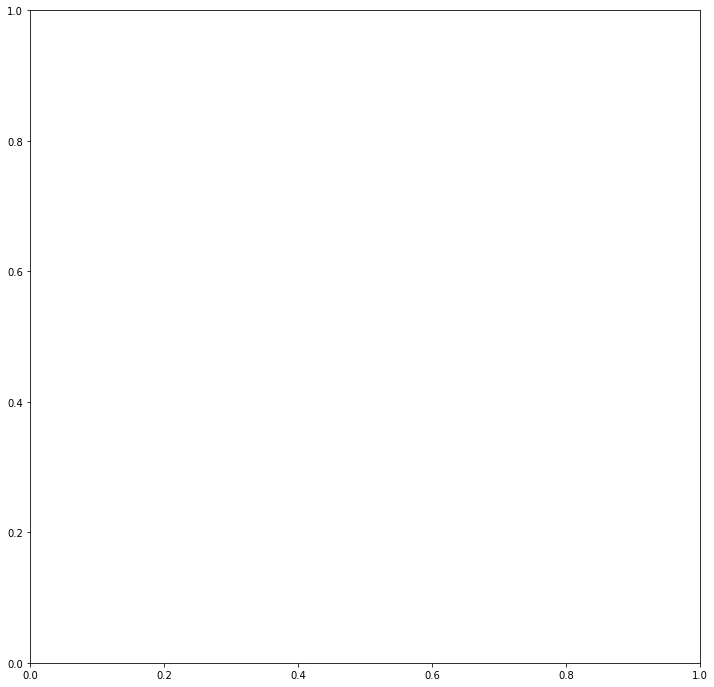

In [24]:
fig = plt.figure(1)
fig.set_size_inches(12, 12, forward=True)

ax = plt.subplot(111)

ax.imshow(amp_filtered, vmin=vel_min, vmax=vel_max, cmap='inferno')
ax.grid(False)

if reg_num == 0:
    last_pos = -step_in_mm
        
last_pos = summarize_velocity_profiles(amp_filtered, df, ax, last_pos, n)
plt.show()



In [119]:
p = 'y:\\projects\\pn-reduction\\2018_09_esrf_me1516\\Phantom\\' + dataset + '\\' + dataset + '_results_all_regions.xlsx' 
print(p)
df.to_excel(p, sheet_name='Results')

y:\projects\pn-reduction\2018_09_esrf_me1516\Phantom\17_3_7_3\17_3_7_3_results_all_regions.xlsx


In [17]:
v = df['y:0.0mm'].values.astype(np.float)
x = df['Dist'].values.astype(np.float)


plt.plot(x, v)
plt.ylim(50, 170)
plt.show()

NameError: name 'df' is not defined

## Testing

In [97]:
def test_averaging_methods_correlation(): 
    
    #------------------------------------------------
    # Filtering according to physical contraints
    #------------------------------------------------
    
    width = 512
    height = 256
    
    cx = int(width / 2) 
    cy = int(height / 2)
    
    min_vel_in_pixels = 0
    max_vel_in_pixels = 20
    
    filtered_amp = np.where(np.all([images > min_vel_in_pixels, images < max_vel_in_pixels], axis=0), images, 0)
    amp_filtered_mean = np.apply_along_axis(avg_nonzero, 0, filtered_amp)
    im_res = Image.fromarray(amp_filtered_mean*vel_factor)
    im_res.save(results_path + 'test_amp_mean_filter.tif')
    
    print(np.mean(amp_filtered_mean[cy-ry:cy+ry,cx-rx:cx+rx]*vel_factor))
    
    
    c_list = np.arange(0, 0.4, 0.02)
    res = []
    
    for c in tqdm(c_list):
            
        filtered_corr = np.where(corr > c, 1, 0)
        filtered_amp2 = filtered_amp*filtered_corr
        amp_filtered_mean = np.apply_along_axis(avg_nonzero, 0, filtered_amp2)

        #im_res = Image.fromarray(amp_filtered_mean*vel_factor)
        #im_res.save(results_path + 'test_amp_mean_filter_corr.tif')

        mean_vel_in_center = np.mean(amp_filtered_mean[cy-ry:cy+ry,cx-rx:cx+rx]*vel_factor)
        
        res.append(mean_vel_in_center)
        
        #print(mean_vel_in_center)
    
    plt.plot(c_list, res)
    plt.title('No magnitude filtering, Minimal valid correlation')
    plt.xlabel('Correlation coefficient')
    plt.ylabel('Velocity, m/s')
    plt.show()
    
    print(res)
    #data_amp = amp_filtered_mean*vel_factor
    
    #plt.hist(data_amp.flatten())
    #plt.show()

In [14]:
def test_averaging_methods_min_max(): 
    
    #------------------------------------------------
    # Filtering according to physical contraints
    #------------------------------------------------
    
    width = 1024
    height = 512
    
    cx = int(width / 2) 
    cy = int(height / 2)
    
    amp_mean = np.mean(images, axis=0)
    amp_mean_value = np.mean(amp_mean[cy-ry:cy+ry,cx-rx:cx+rx])
    print('Mean unfiltered:', amp_mean_value*vel_factor)
    
    filtered_corr = np.where(corr > min_corr_value, 1, 0)
    
    #amp_median = np.median(images, axis=0)
    #print('Median unfiltered:', np.mean(amp_median[cy-ry:cy+ry,cx-rx:cx+rx]*vel_factor))
    
    # Make outliers filtering
    min_vel_in_pixels = (1.0 - 0.5)*amp_mean_value
    max_vel_in_pixels = (1.0 + 0.5)*amp_mean_value
    
    print('Velocity outliers:', min_vel_in_pixels*vel_factor, max_vel_in_pixels*vel_factor)

    filtered_amp = np.where(np.all([images > min_vel_in_pixels, images < max_vel_in_pixels], axis=0), images, 0)
    amp_filtered_mean = np.apply_along_axis(avg_nonzero, 0, filtered_amp)
    amp_mean_filtered_value = np.mean(amp_filtered_mean[cy-ry:cy+ry,cx-rx:cx+rx])
    print('Mean 50% outliers filtered:', amp_mean_filtered_value*vel_factor)
    
    amp_filtered_mean = np.apply_along_axis(avg_nonzero, 0, filtered_amp*filtered_corr)
    amp_mean_filtered_value = np.mean(amp_filtered_mean[cy-ry:cy+ry,cx-rx:cx+rx])
    print('Mean 50% outliers filtered, correlation filtered:', amp_mean_filtered_value*vel_factor)
    
      
    perc = np.arange(0.1, 0.7, 0.05)
    #perc = np.array([0.1, 0.25, 0.5])
    
    res_unfiltered = []
    res_filtered = []
    
    for p in tqdm(perc):
    
        min_vel_in_pixels = (1.0 - p)*amp_mean_value
        max_vel_in_pixels = (1.0 + p)*amp_mean_value
    
        filtered_amp = np.where(np.all([images > min_vel_in_pixels, images < max_vel_in_pixels], axis=0), images, 0)
        amp_filtered_mean = np.apply_along_axis(avg_nonzero, 0, filtered_amp*filtered_corr)
        mean_vel_in_center = np.mean(amp_filtered_mean[cy-ry:cy+ry,cx-rx:cx+rx]*vel_factor)
    
        res_unfiltered.append(mean_vel_in_center)
        
        min_vel_in_pixels = (1.0 - p)*amp_mean_filtered_value
        max_vel_in_pixels = (1.0 + p)*amp_mean_filtered_value
    
        filtered_amp = np.where(np.all([images > min_vel_in_pixels, images < max_vel_in_pixels], axis=0), images, 0)
        amp_filtered_mean = np.apply_along_axis(avg_nonzero, 0, filtered_amp*filtered_corr)
        mean_vel_in_center = np.mean(amp_filtered_mean[cy-ry:cy+ry,cx-rx:cx+rx]*vel_factor)
    
        res_filtered.append(mean_vel_in_center)
    
    return res_unfiltered, res_filtered
    
    #print(res)
    #data_amp = amp_filtered_mean*vel_factor
    
    #plt.hist(data_amp.flatten())
    #plt.show()

In [7]:
test_averaging_methods_correlation()



NameError: name 'test_averaging_methods_correlation' is not defined

In [58]:
res_unfiltered, res_filtered = test_averaging_methods_min_max()

Mean unfiltered: 133.0679785121571
Velocity outliers: 66.53398925607856 199.60196776823568
Mean 50% outliers filtered: 142.6377735354684
Mean 50% outliers filtered, correlation filtered: 141.5551656627158


100%|██████████████████████████████████████████| 12/12 [06:59<00:00, 35.35s/it]


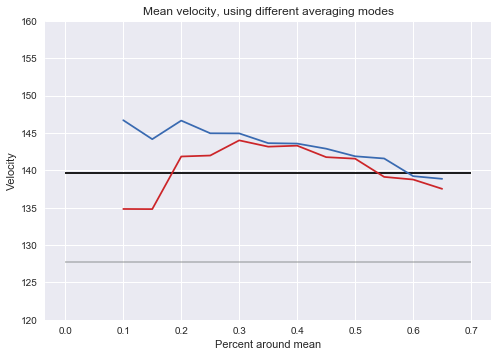

In [59]:
#print(res)

plt.style.use('seaborn')

perc = np.arange(0.1, 0.7, 0.05)

plt.plot(perc, res_unfiltered, color=red)
plt.plot(perc, res_filtered, color=blue)
plt.hlines(127.76, 0, 0.7, color=grey, alpha=0.5)
plt.hlines(139.6, 0, 0.7, color='black')
plt.title('Mean velocity, using different averaging modes')
plt.xlabel('Percent around mean')
plt.ylabel('Velocity')
plt.ylim(120, 160)
plt.savefig('y:\\projects\\pn-reduction\\2018_09_esrf_me1516\\Phantom\\' + dataset + '\\' + dataset + '_d7.5_vel_filtering_fig.png')
plt.show()


In [16]:
print(11*1.5)
print(11*0.5)

16.5
5.5


## Processing: All datasets

Processing dataset:  17_3_5_1

Processing region: 0
Time elapsed:  68.79768872261047
Analysis...
Image size 1024 512
Mean unfiltered, center: 149.4701060381803
Velocity outliers: 74.73505301909015 224.20515905727044
Mean 50% outliers and correlation filtered: 150.4134022183675
OK
Done

Processing region: 2.5
Time elapsed:  65.88965964317322
Analysis...
Image size 1024 512
Mean unfiltered, center: 144.31423707441851
Velocity outliers: 72.15711853720926 216.47135561162779
Mean 50% outliers and correlation filtered: 148.12024607967945
OK
Done

Processing region: 5
Time elapsed:  91.4789171218872
Analysis...
Image size 1024 512
Mean unfiltered, center: 137.55261247808286
Velocity outliers: 68.77630623904143 206.32891871712428
Mean 50% outliers and correlation filtered: 146.15968735958666
OK
Done

Processing region: 7.5
Time elapsed:  68.98569655418396
Analysis...
Image size 1024 512
Mean unfiltered, center: 130.72917515581307
Velocity outliers: 65.36458757790653 196.0937627337196
Mean 50% 

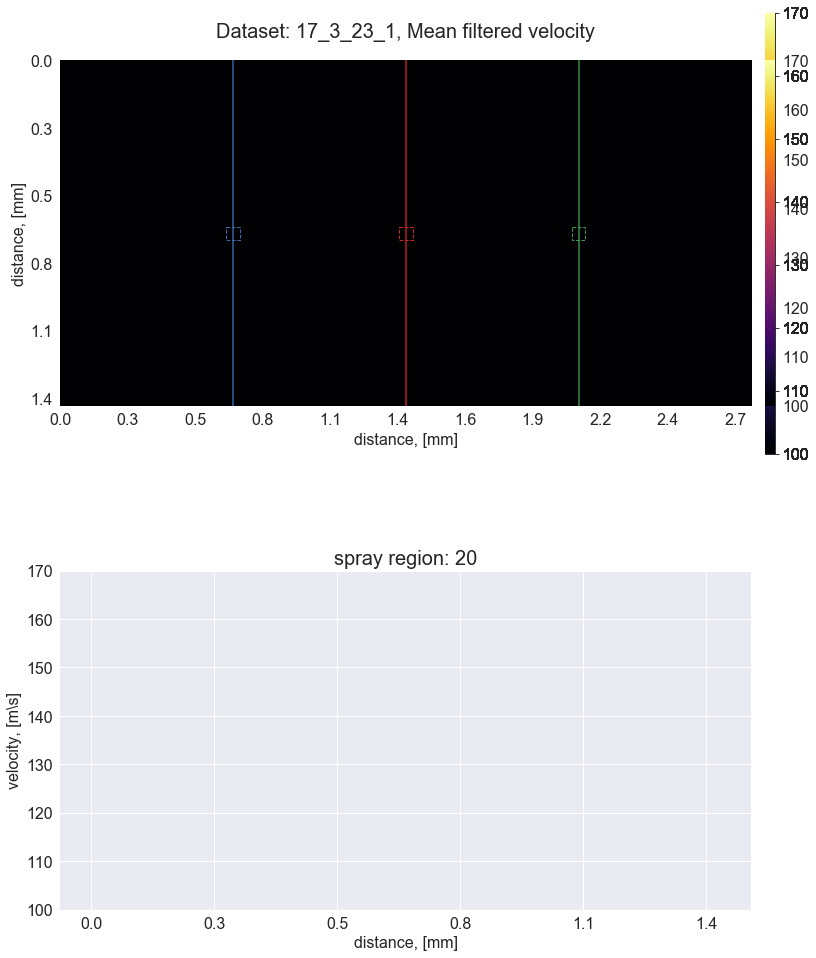

In [21]:

all_data_frames = []

datasets = ['17_3_5_1', '17_3_7_3','17_3_23_1']
regions = ['0', '2.5', '5', '7.5', '10', '12.5', '15', '17.5', '20']

pd.set_option('display.width', 1000)

# Patch size for measurement
px = 5
py = 5

step_in_mm = 0.1
step_in_pixels = int(step_in_mm * 1000 / pixel_size)
    
n = 11 # Number of vertical regions to measure

for ds in datasets:
    
    dataset = ds
    
    print('=====================================')
    print('Processing dataset: ', ds)
    print('=====================================')

    # Create an empty data frame
    vert_values = ['y:{0:.1f}mm'.format(x*step_in_pixels*pixel_size /1000) for x in np.arange(-(n-1)/2, (n-1)/2+1)]
    columns = ['Dataset', 'Tile', 'Dist'] + vert_values
    df = pd.DataFrame(columns=columns )

    for r in regions:

        region = r

        print('\nProcessing region:', r)

        path_input = 'y:\\projects\\pn-reduction\\2018_09_esrf_me1516\\Phantom\\' + dataset + '\\' + dataset + '_Tile_d' +region + '\\'
        #path_input = 'y:\\projects\\pn-reduction\\2018_09_esrf_me1516\\Phantom\\test\\' + dataset + '_Tile_d' +region + '\\'
        results_path = path_input
        file_name = dataset + '_Tile_d' +region+'.tif'

        # Read date
        start = time.time()    
        images = read_tiff(path_input + dataset + '_Tile_d' +region +'_amp_seq.tif', max_read_images)
        corr   = read_tiff(path_input + dataset + '_Tile_d' +region + '_corr_seq.tif', max_read_images)
        end = time.time()
        print ('Time elapsed: ', (end-start))

        plot_velocity_map = True
        plot_profiles = True
        plot_time_evolution = False

        amp, corr, amp_filtered = make_analysis_figure()

        reg_num = regions.index(r)
        if reg_num == 0:
            last_pos = -step_in_mm

        # Measure velocity profiles
        last_pos = summarize_velocity_profiles(amp_filtered, df, last_pos, n)

        print('Done')


    all_data_frames.append(df)

    print('Finished')
    p = 'y:\\projects\\pn-reduction\\2018_09_esrf_me1516\\Phantom\\' + dataset + '\\' 
    df.to_excel(p + dataset + '_results_all_regions.xlsx', sheet_name='Results')
    df.to_pickle(p + dataset + '_results_all_regions.pkl')
    print('Saved')

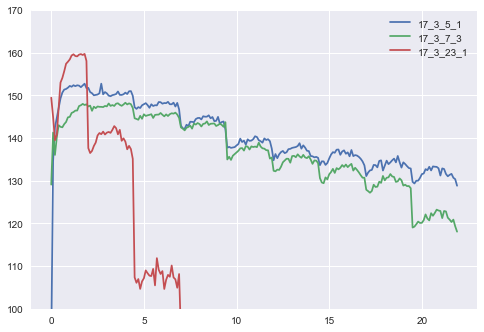

In [25]:
i = 0
for df in all_data_frames:
    # Plot result
    
    dname = datasets[i]
    v1 = df['y:0.0mm'].values.astype(np.float)
    v2 = df['y:-0.1mm'].values.astype(np.float)
    v4 = df['y:-0.2mm'].values.astype(np.float)
    x = df['Dist'].values.astype(np.float)

    v = [v1,v2,v4]

    v = np.mean(v, axis=0)

    plt.plot(x,v, label= dname)
    plt.ylim(100, 170)
    i = i+1
    
plt.legend()
plt.show()    

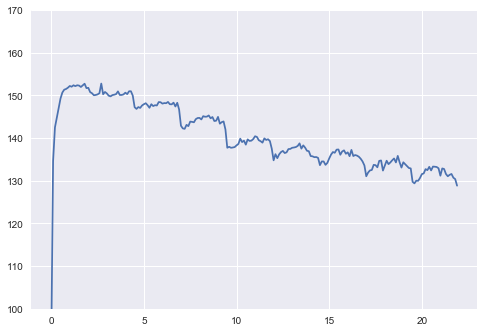

array([ 30.2, 133.6, 142.6, 147.9, 150.4, 151.5, 152.2, 151.5, 152.1,
       151.8, 152.1, 152. , 151.3, 151.6, 151.6, 151.6, 150.4, 151.5,
       150.9, 150.8, 151.7, 150.6, 150.2, 150.4, 150.3, 149.5, 150.6,
       152.8, 149.6, 150.9, 150. , 150.1, 149.8, 149.4, 149.7, 149.8,
       150.8, 150. , 150.3, 150.2, 149.9, 150.9, 150.6, 150.3, 149.3,
       147. , 147.2, 147.6, 147.4, 147.8, 147.7, 147.3, 148.4, 147.2,
       148.6, 147.6, 147.4, 147.3, 148.9, 147.8, 147.4, 148.4, 148.4,
       149. , 148.3, 147.8, 148.3, 146.4, 147.4, 145.3, 142.4, 142.1,
       142.4, 143.3, 143.9, 144.2, 142.7, 143.9, 144.1, 144.6, 144.8,
       144.9, 145.2, 144.8, 144.3, 145.2, 144.5, 145.2, 143.5, 143.2,
       144.8, 143.2, 143.7, 144. , 140.1, 137.1, 138.9, 137.9, 138.6,
       138.6, 138.2, 139.2, 140. , 138.9, 138.4, 138.4, 139.6, 139.4,
       139.9, 138.4, 139.8, 140. , 139.5, 138.7, 138.1, 140.8, 140.2,
       139.6, 138.8, 136.5, 136.2, 136.6, 135.4, 136.1, 136.4, 136.4,
       137. , 137.1,

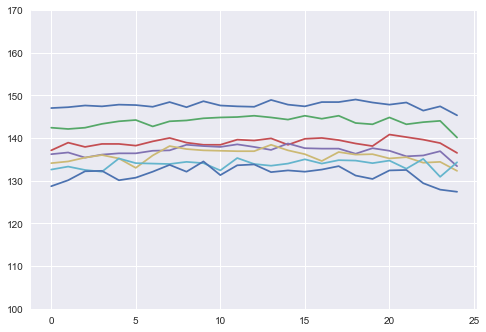

array([142.4, 142.1, 142.4, 143.3, 143.9, 144.2, 142.7, 143.9, 144.1,
       144.6, 144.8, 144.9, 145.2, 144.8, 144.3, 145.2, 144.5, 145.2,
       143.5, 143.2, 144.8, 143.2, 143.7, 144. , 140.1])

In [40]:
v1 = df[df.Tile == '5']['y:0.0mm'].values.astype(np.float)
v2 = df[df.Tile == '7.5']['y:0.0mm'].values.astype(np.float)
v3 = df[df.Tile == '10']['y:0.0mm'].values.astype(np.float)
v4 = df[df.Tile == '12.5']['y:0.0mm'].values.astype(np.float)
v5 = df[df.Tile == '15']['y:0.0mm'].values.astype(np.float)
v6 = df[df.Tile == '17.5']['y:0.0mm'].values.astype(np.float)
v7 = df[df.Tile == '20']['y:0.0mm'].values.astype(np.float)

x = df[df.Tile == '7.5']['Dist'].values.astype(np.float)

plt.plot(v1)
plt.plot(v2)
plt.plot(v3)
plt.plot(v4)
plt.plot(v5)
plt.plot(v6)
plt.plot(v7)

plt.ylim(100, 170)
plt.show()
v

In [89]:
# Shift for 1mm in pixels

## -----------------------------------
## Testing: Filtering with peak height
## -----------------------------------

In [29]:



def filter_and_summarize_velocities(amp, corr, peaks, flow_x, flow_y):
    
    width = amp.shape[2]
    height = amp.shape[1]

    cx = int(width / 2) 
    cy = int(height / 2)

    rx = 20
    ry = 10
    
    # 1. Mean velocity without any filtering
    amp_mean = np.mean(images, axis=0)
    amp_mean_unfiltered_center = np.mean(amp_mean[cy-ry:cy+ry,cx-rx:cx+rx])

    im_res = Image.fromarray(amp_mean*vel_factor)
    im_res.save(results_path + dataset + '_Tile_d' +region + '_amp_mean_nofilter.tif')
    amp_mean = np.mean(images, axis=0)
    print('mean:', amp_mean_unfiltered_center*vel_factor)

    # 2. Mean velocity with filtering on the correlation coefficient
    filtered_corr = np.where(corr > min_corr_value, 1, 0)

    filtered_corr_mean = avg_non_zero_full(images*filtered_corr)
    amp_mean_filtered_corr_center = np.mean(filtered_corr_mean[cy-ry:cy+ry,cx-rx:cx+rx])

    im_res = Image.fromarray(filtered_corr_mean*vel_factor)
    im_res.save(results_path + dataset + '_Tile_d' +region + '_amp_mean_filter_corr.tif')
    print('corr>0.2, center:', amp_mean_filtered_corr_center*vel_factor)

    # 3. Mean velocity with filtering on velocities
    perc_filtering_threshold = 0.5
    amp_mean_truth = 10

    min_vel_in_pixels = (1.0 - perc_filtering_threshold)*amp_mean_truth
    max_vel_in_pixels = (1.0 + perc_filtering_threshold)*amp_mean_truth

    filtered_amp_seq = np.where(np.all([images > min_vel_in_pixels, images < max_vel_in_pixels, np.abs(flow_x) > np.abs(flow_y)], axis=0), images, 0)

    filtered_amp_mean  = avg_non_zero_full(filtered_amp_seq)
    amp_mean_filtered_center = np.mean(filtered_amp_mean[cy-ry:cy+ry,cx-rx:cx+rx])

    im_res = Image.fromarray(filtered_amp_mean*vel_factor)
    im_res.save(results_path + dataset + '_Tile_d' +region + '_amp_mean_filter_amp.tif')
    print('amp +/- 50%:', amp_mean_filtered_center*vel_factor)

    # 4. Mean velocity with filtering on local peak height
    filtered_peak = np.where(peak > corr / 2.0, 1, 0)

    filtered_peak_mean = avg_non_zero_full(vec_mul3(images,filtered_corr,filtered_peak))
    amp_mean_filtered_center = np.mean(filtered_peak_mean[cy-ry:cy+ry,cx-rx:cx+rx])

    im_res = Image.fromarray(filtered_peak_mean*vel_factor)
    im_res.save(results_path + dataset + '_Tile_d' +region + '_amp_mean_filter_peak.tif')
    print('peak:', amp_mean_filtered_center*vel_factor)

    # 5. Mean velocity with filtering on all constraints
    filtered_all_mean = avg_non_zero_full(vec_mul3(filtered_amp_seq,filtered_corr,filtered_peak))
    amp_mean_filtered_center = np.mean(filtered_all_mean[cy-ry:cy+ry,cx-rx:cx+rx])

    im_res = Image.fromarray(filtered_all_mean*vel_factor)
    im_res.save(results_path + dataset + '_Tile_d' +region + '_amp_mean_filter_all.tif')
    print('all:', amp_mean_filtered_center*vel_factor)
    
    return amp_mean, filtered_corr_mean, filtered_amp_mean, filtered_peak_mean, filtered_all_mean  

    

Mean: 149.8739150437442
corr>0.2, center: 151.0365404845071
amp +/- 50%: 152.25017179142347
peak: 155.22494502594077
all: 155.20495444425788


In [25]:


# Mean velocity without any filtering
start = time.time()
amp_mean = np.mean(images, axis=0)
print('Elapsed:', time.time() - start)
amp_mean_unfiltered_center = np.mean(amp_mean[cy-ry:cy+ry,cx-rx:cx+rx])

im_res = Image.fromarray(amp_mean*vel_factor)
im_res.save(results_path + dataset + '_Tile_d' +region + '_amp_mean_nofilter.tif')
amp_mean = np.mean(images, axis=0)
print('Mean:', amp_mean_unfiltered_center*vel_factor)

Elapsed: 0.1100010871887207
Mean: 149.8739150437442


In [26]:
start = time.time()
filtered_corr = np.where(corr > min_corr_value, 1, 0)

filtered = images*filtered_corr
filtered_mean = avg_non_zero_full(filtered)
amp_mean_filtered_corr_center = np.mean(filtered_mean[cy-ry:cy+ry,cx-rx:cx+rx])
print('Elapsed:', time.time() - start)

im_res = Image.fromarray(filtered_mean*vel_factor)
im_res.save(results_path + dataset + '_Tile_d' +region + '_amp_mean_filter_corr.tif')
print('corr>0.2, center:', amp_mean_filtered_corr_center*vel_factor)


Elapsed: 2.5910258293151855
corr>0.2, center: 151.0365404845071


In [27]:
start = time.time()
filtered_peak = np.where(peak > corr / 2.0, 1, 0)

filtered_amp = avg_non_zero_full(vec_mul3(images,filtered_corr,filtered_peak))
amp_mean_filtered_center = np.mean(filtered_amp[cy-ry:cy+ry,cx-rx:cx+rx])
print('Elapsed:', time.time() - start)

im_res = Image.fromarray(filtered_amp*vel_factor)
im_res.save(results_path + dataset + '_Tile_d' +region + '_amp_mean_filter_peak.tif')
print('peak:', amp_mean_filtered_center*vel_factor)

Elapsed: 2.9400293827056885
peak: 155.22494502594077


In [28]:
start = time.time()
perc_filtering_threshold = 0.5
amp_mean_truth = 10

min_vel_in_pixels = (1.0 - perc_filtering_threshold)*amp_mean_truth
max_vel_in_pixels = (1.0 + perc_filtering_threshold)*amp_mean_truth

filtered_amp_seq = np.where(np.all([images > min_vel_in_pixels, images < max_vel_in_pixels, np.abs(flow_x) > np.abs(flow_y)], axis=0), images, 0)
filtered_amp = avg_non_zero_full(filtered_amp_seq)
print('Elapsed:', time.time() - start)

amp_mean_filtered_center = np.mean(filtered_amp[cy-ry:cy+ry,cx-rx:cx+rx])

im_res = Image.fromarray(filtered_amp*vel_factor)
im_res.save(results_path + dataset + '_Tile_d' +region + '_amp_mean_filter_amp.tif')
print('amp +/- 50%:', amp_mean_filtered_center*vel_factor)


Elapsed: 2.9300291538238525
amp +/- 50%: 152.25017179142347


In [24]:
filtered_amp = avg_non_zero_full(vec_mul3(filtered_amp_seq,filtered_corr,filtered_peak))
amp_mean_filtered_center = np.mean(filtered_amp[cy-ry:cy+ry,cx-rx:cx+rx])

im_res = Image.fromarray(filtered_amp*vel_factor)
im_res.save(results_path + dataset + '_Tile_d' +region + '_amp_mean_filter_all.tif')
print('all:', amp_mean_filtered_center*vel_factor)

all: 155.20495444425788


In [ ]:
# TODO velocity

In [ ]:

#------------------------------------------------
# Filtering according to physical contraints
#------------------------------------------------

# Make outliers filtering
min_vel_in_pixels = (1.0 - perc_outliers_threshold)*amp_mean_unfiltered_center
max_vel_in_pixels = (1.0 + perc_outliers_threshold)*amp_mean_unfiltered_center

print('Velocity outliers:', min_vel_in_pixels*vel_factor, max_vel_in_pixels*vel_factor)

filtered_amp = np.where(np.all([images > min_vel_in_pixels, images < max_vel_in_pixels], axis=0), images, 0)
amp_filtered_mean = np.apply_along_axis(avg_nonzero, 0, filtered_amp*filtered_corr)
amp_mean_filtered_value = np.mean(amp_filtered_mean[cy-ry:cy+ry,cx-rx:cx+rx])

print('Mean 50% outliers and correlation filtered:', amp_mean_filtered_value*vel_factor)

min_vel_in_pixels = (1.0 - perc_filtering_threshold)*amp_mean_unfiltered_center
max_vel_in_pixels = (1.0 + perc_filtering_threshold)*amp_mean_unfiltered_center

filtered_amp = np.where(np.all([images > min_vel_in_pixels, images < max_vel_in_pixels], axis=0), images, 0)
amp_filtered_mean = np.apply_along_axis(avg_nonzero, 0, filtered_amp*filtered_corr)
im_res = Image.fromarray(amp_filtered_mean*vel_factor)
im_res.save(results_path + dataset + '_Tile_d' +region + '_amp_mean_filter.tif')


In [136]:
real = 1000 / 387
print('Estimated pixel size:',real)

Estimated pixel size: 2.5839793281653747


In [137]:
print('Difference estimated/theoretical:', real / 2.7)


Difference estimated/theoretical: 0.9570293808019905


In [139]:
145 * 0.95

137.75

In [40]:
1025 * pixel_size

2767.5

In [51]:
2306 - 2240

66

In [43]:
start_indexes = np.arange(66,3300, 220)
end_indexes   = start_indexes + 80

In [44]:
print(start_indexes)
print(end_indexes)

[  66  286  506  726  946 1166 1386 1606 1826 2046 2266 2486 2706 2926
 3146]
[ 146  366  586  806 1026 1246 1466 1686 1906 2126 2346 2566 2786 3006
 3226]


In [49]:
s = np.array([66, 290, 514, 738, 962, 1186, 1410, 1634, 1858, 2082, 2307])
e = np.array([160, 383, 607, 831, 1056, 1280, 1503, 1727, 1951, 2175, 2400])

print('Start dist:', s[1:] - s[:-1])
print('End dist:', e[1:] - e[:-1])

Start dist: [224 224 224 224 224 224 224 224 224 225]
End dist: [223 224 224 225 224 223 224 224 224 225]


In [50]:
print('Duration:', e - s)

Duration: [94 93 93 93 94 94 93 93 93 93 93]


In [56]:
print(s.tolist().index(290))

1


In [26]:
2.7 * 1024 / 1000

2.7648

In [26]:
0.1 * 2.7 * 1000

270.0

In [27]:
100 / 2.7

37.03703703703704

In [107]:
image_width = 1024*pixel_size / 1000 # in mm
shift = 2.5 # in mm

offset = (image_width - shift) * 1000 / pixel_size # in pixels
offset

98.07407407407412

In [12]:
11 * 1.25

13.75

In [10]:
columns = ['d', 'values']
df = pd.DataFrame(columns=columns)

res = ['x', 56.125324]
df.loc[len(df)] = res

In [11]:
df

,d,values
0,x,56.125324


In [15]:
df.to_excel('e:\\Data\\test\\test.xlsx', sheet_name='Results')

In [22]:
10*vel_factor

153.40909090909093

In [27]:
len(images)

700

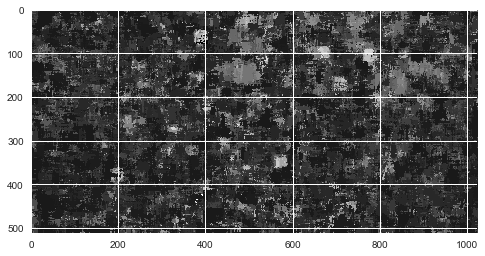

In [30]:
im = images[0]
plt.imshow(im, cmap='gray')
plt.show()

(array([   74,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,    64,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0, 88903,     0,
           0, 71606,     0,     0,     0,     0,     0,     0,     0,
       20470,     0, 45325,     0, 40922,     0,     0,     0,     0,
           0, 23182,     0,     0,     0,     0, 33568,     0, 24587,
        5993,     0,     0, 14748,     0,     0,     0,     0,     0,
           0, 23951, 13939,     0,     0,     0,  5955,     0,     0,
        1966,     0,     0,  2750,     0, 11072,  6740,     0,     0,
        3864,  1474,     0,     0,     0,  1905,     0,     0,     0,
        7253,  5531,   831,  2910,     0,     0,     0,     0,  1364,
           0,   725,     0,     0, 14114,     0,     0,  1869,     0,
           0,   144,  1511,     0,     0,     0,     0,  6497,  5130,
           0,  2608,     0,     0,   478,   803,     0,     0,     0,
         475,   146

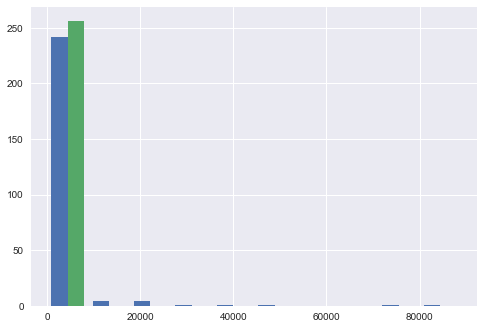

In [37]:
h = np.histogram(im.flatten(), bins=255)

print(h)
plt.hist(h)
plt.show()

In [8]:
## Test: Performance

In [10]:
filtered= np.where(images > 7, 1, 0)


In [11]:
start = time.time()
filtered_mean = np.apply_along_axis(avg_nonzero, 0, filtered)
print('Elapsed:', time.time() - start)

print(np.mean(filtered_mean))

Elapsed: 14.337181091308594
0.9997215270996094


In [14]:
start = time.time()
filtered_mean2 = np.apply_along_axis(avg_non_zero_numba, 0, filtered)
print('Elapsed:', time.time() - start)

print(np.mean(filtered_mean2))

Elapsed: 7.618077039718628
0.9997215270996094


In [21]:
start = time.time()
filtered_mean3 = avg_non_zero_full(filtered)
print('Elapsed:', time.time() - start)

print(np.mean(filtered_mean3))


Elapsed: 6.440073490142822
0.9997215270996094


TypingError: Failed at nopython (nopython frontend)
[33m[1m[33m[1mUnknown attribute 'shape' of type float64
[37m[1m
File "<ipython-input-20-e254c1793b5c>", line 695:[0m
[34m[1mdef avg_non_zero_full(a):
    <source elided>
    
[31m[1m    nz = a.shape[0]
[0m    [32m[1m^[0m[0m
[0m
[0m[37m[1m[1] During: typing of get attribute at <ipython-input-20-e254c1793b5c> (695)[0m
[37m[1m
File "<ipython-input-20-e254c1793b5c>", line 695:[0m
[34m[1mdef avg_non_zero_full(a):
    <source elided>
    
[31m[1m    nz = a.shape[0]
[0m    [32m[1m^[0m[0m
